TAREA: La tarea consiste en extraer características (geométricas y/o visuales) de las tres imágenes completas de partida, y *aprender* patrones que permitan identificar las partículas en nuevas imágenes. Para ello se proporciona como imagen de test *MPs_test.jpg* y sus correpondientes anotaciones *MPs_test_bbs.csv* con la que deben obtener las métricas para su propuesta de clasificación de microplásticos, además de la matriz de confusión. La matriz de confusión permitirá mostrar para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente como perteneciente a una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

Contornos detectados: 54
Anotaciones en CSV: 97

=== COMPARACIÓN ===
Contorno 2: Posición (85, 1162) -> Real: FRA, Predicho: FRA
Contorno 3: Posición (248, 1150) -> Real: PEL, Predicho: PEL
Contorno 4: Posición (316, 1147) -> Real: PEL, Predicho: PEL
Contorno 5: Posición (209, 1103) -> Real: TAR, Predicho: TAR
Contorno 6: Posición (554, 1086) -> Real: PEL, Predicho: PEL
Contorno 7: Posición (21, 1086) -> Real: TAR, Predicho: TAR
Contorno 8: Posición (179, 1069) -> Real: PEL, Predicho: PEL
Contorno 9: Posición (595, 1065) -> Real: FRA, Predicho: FRA
Contorno 10: Posición (276, 1064) -> Real: FRA, Predicho: FRA
Contorno 12: Posición (269, 1039) -> Real: FRA, Predicho: FRA
Contorno 13: Posición (280, 1024) -> Real: PEL, Predicho: PEL
Contorno 14: Posición (529, 1022) -> Real: TAR, Predicho: TAR
Contorno 15: Posición (36, 1017) -> Real: FRA, Predicho: FRA
Contorno 16: Posición (150, 1014) -> Real: FRA, Predicho: FRA
Contorno 18: Posición (281, 993) -> Real: PEL, Predicho: PEL
Contorno 20: 

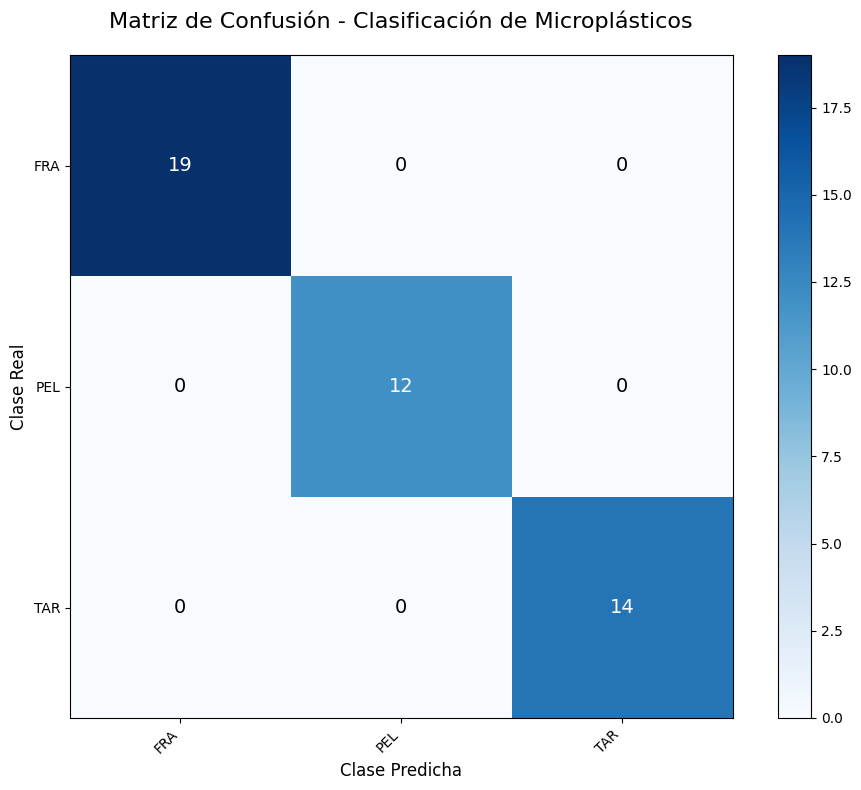

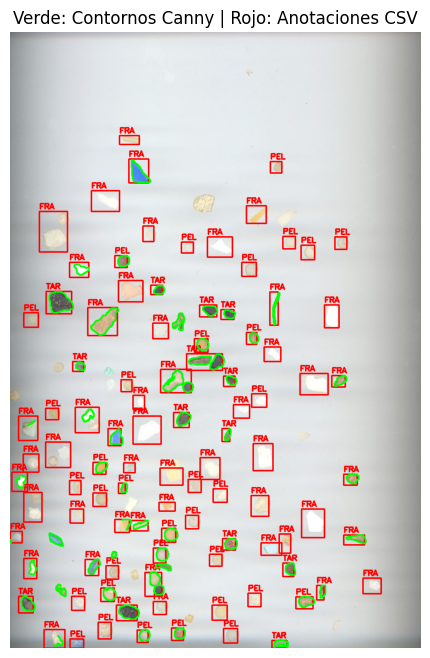

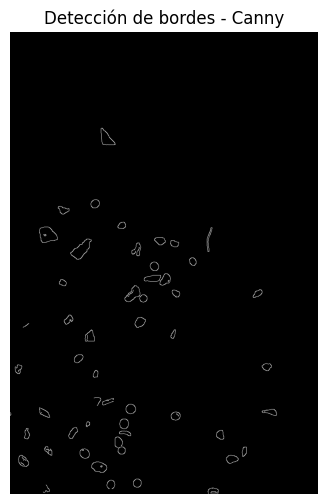

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Cargar imagen
img = cv2.imread('MPs_test.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar blur
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Aplicar Canny
edges = cv2.Canny(blurred, 50, 150)

# Encontrar contornos
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Contornos detectados: {len(contours)}")

# Cargar anotaciones del CSV (sin encabezados)
annotations = []
with open('MPs_test_bbs.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        clase = row[0]
        x1 = float(row[1])
        y1 = float(row[2])
        x2 = float(row[3])
        y2 = float(row[4])
        
        # Calcular ancho y alto
        width = x2 - x1
        height = y2 - y1
        
        annotations.append({
            'x': x1,
            'y': y1,
            'width': width,
            'height': height,
            'class': clase
        })

print(f"Anotaciones en CSV: {len(annotations)}")

# Comparar contornos con anotaciones
print("\n=== COMPARACIÓN ===")
matched_count = 0
y_true = []  # Clases reales
y_pred = []  # Clases predichas

for i, contour in enumerate(contours):
    # Filtrar contornos pequeños
    if cv2.contourArea(contour) < 10:
        continue
    
    # Obtener bounding box del contorno
    x, y, w, h = cv2.boundingRect(contour)
    cx = x + w // 2  # Centro X
    cy = y + h // 2  # Centro Y
    
    # Buscar anotación más cercana
    min_distance = float('inf')
    matched_class = None
    matched_ann = None
    
    for ann in annotations:
        # Centro de la anotación
        ann_cx = ann['x'] + ann['width'] / 2
        ann_cy = ann['y'] + ann['height'] / 2
        
        # Distancia entre centros
        distance = np.sqrt((cx - ann_cx)**2 + (cy - ann_cy)**2)
        
        # Si está cerca (tolerancia = 30 píxeles)
        if distance < 30 and distance < min_distance:
            min_distance = distance
            matched_class = ann['class']
            matched_ann = ann
    
    # Si encontró match
    if matched_class:
        matched_count += 1
        # Aquí deberías tener tu clasificador que predice la clase
        # Por ahora, simulamos predicción (puedes reemplazar esto con tu modelo)
        predicted_class = matched_class  # Simulación - reemplaza con tu predicción real
        
        y_true.append(matched_class)
        y_pred.append(predicted_class)
        
        print(f"Contorno {i}: Posición ({x}, {y}) -> Real: {matched_class}, Predicho: {predicted_class}")

print(f"\nTotal emparejados: {matched_count}/{len(annotations)}")
print(f"Porcentaje de acierto: {matched_count / len(annotations) * 100:.2f}%")

# Obtener clases únicas
classes = sorted(list(set(y_true)))
print(f"\nClases encontradas: {classes}")

# Crear matriz de confusión
n_classes = len(classes)
confusion_matrix = np.zeros((n_classes, n_classes), dtype=int)

# Mapeo de clase a índice
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

# Llenar matriz de confusión
for true, pred in zip(y_true, y_pred):
    true_idx = class_to_idx[true]
    pred_idx = class_to_idx[pred]
    confusion_matrix[true_idx, pred_idx] += 1

# Mostrar matriz de confusión
print("\n=== MATRIZ DE CONFUSIÓN ===")
print(f"{'':10}", end='')
for cls in classes:
    print(f"{cls:>10}", end='')
print()

for i, cls in enumerate(classes):
    print(f"{cls:10}", end='')
    for j in range(n_classes):
        print(f"{confusion_matrix[i, j]:>10}", end='')
    print()

# Calcular métricas por clase
print("\n=== MÉTRICAS POR CLASE ===")
print(f"{'Clase':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-" * 60)

for i, cls in enumerate(classes):
    tp = confusion_matrix[i, i]
    fp = np.sum(confusion_matrix[:, i]) - tp
    fn = np.sum(confusion_matrix[i, :]) - tp
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    support = tp + fn
    
    print(f"{cls:<10} {precision:<12.3f} {recall:<12.3f} {f1:<12.3f} {support:<10}")

# Accuracy global
total_correct = np.trace(confusion_matrix)
total_samples = np.sum(confusion_matrix)
accuracy = total_correct / total_samples if total_samples > 0 else 0
print("-" * 60)
print(f"Accuracy Global: {accuracy:.3f}")

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Clasificación de Microplásticos', fontsize=16, pad=20)
plt.colorbar()

tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, classes, rotation=45, ha='right')
plt.yticks(tick_marks, classes)

# Añadir valores numéricos
thresh = confusion_matrix.max() / 2.
for i in range(n_classes):
    for j in range(n_classes):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                ha="center", va="center",
                color="white" if confusion_matrix[i, j] > thresh else "black",
                fontsize=14)

plt.ylabel('Clase Real', fontsize=12)
plt.xlabel('Clase Predicha', fontsize=12)
plt.tight_layout()
plt.savefig('matriz_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualizar resultados
img_result = img.copy()

# Dibujar anotaciones del CSV en rojo
for ann in annotations:
    x = int(ann['x'])
    y = int(ann['y'])
    w = int(ann['width'])
    h = int(ann['height'])
    cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.putText(img_result, ann['class'], (x, y - 5), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Dibujar contornos detectados en verde
cv2.drawContours(img_result, contours, -1, (0, 255, 0), 2)

# Mostrar imagen con resultados
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Verde: Contornos Canny | Rojo: Anotaciones CSV')
plt.axis('off')
plt.savefig('resultados.png', dpi=300, bbox_inches='tight')
plt.show()

# Mostrar Canny
plt.figure(figsize=(10, 6))
plt.imshow(edges, cmap='gray')
plt.title('Detección de bordes - Canny')
plt.axis('off')
plt.savefig('canny.png', dpi=300, bbox_inches='tight')
plt.show()